# Adversarial Examples for Vanilla Neural Networks

Adversarial examples are inputs to a neural network that are designed to "trick" neural networks. For example, [here](https://blog.openai.com/robust-adversarial-inputs/) is a cool project that an intern at OpenAI did on adversarial examples. He managed "convince" an image recognition neural network that a picture of a cat was a desktop computer. Adversarial examples are incredibly important when it comes to the security of neural network models and is currently a very active field of research (for example, a [paper](https://arxiv.org/pdf/1611.02770.pdf) from Berkeley's own Dawn Song).

Here is an example of an image of a panda with added noise that a neural network thinks with 99.3% confidence is a gibbon:

![](https://blog.openai.com/content/images/2017/02/adversarial_img_1.png)

This notebook does something similar. It takes a neural network trained to recognize handwritten digits and implements code to generate images that "trick" the neural network. For example, we'll generate images that look like a '2' but the network will think is a '6'. The digits that the network was trained on look something like this:

![](http://neuralnetworksanddeeplearning.com/images/digits.png)

(The neural network was implemented by Michael Nielsen for his [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/) book. We encourage you to read it!)

In [1]:
%matplotlib inline
import network as network
import pickle
import mnist_loader
import matplotlib.pyplot as plt
import numpy as np

Download the pretrained model and the data:

In [2]:
with open('trained_network.pkl', 'rb') as f:
    net = pickle.load(f)
    
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

The network is pretrained, so the network is already set up to predict characters. Run `predict([n])` to evaluate the nth digit in the test set using the network. You should see that the network works really well for about 95% of the images.

Network output: 
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]]

Network prediction: 7

Actual image: 


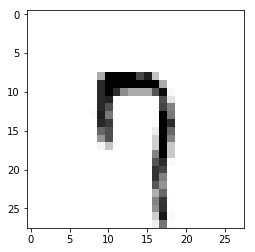

In [3]:
def predict(n):
    # Get the data
    x = test_data[n][0]
    y = test_data[n][1]

    # Print the prediction of the network
    print 'Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n'
    print 'Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n'
    print 'Actual image: '
    
    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')

predict(3498)

A function to generate adversarial examples. We do this by setting a "goal," and then starting with an initial random image. We then perform gradient descent on only that initial random image. In contrast while training the network we perform gradient descent on the weights and biases, but to generate the adversarial example we hold them constant. Our cost function is

$$ C = \|y_{goal} - \hat y(x)\|^2_2 $$

where $ y $ is our goal and $ y_{hat} $ is the network's output. So in full mathy language, our optimization problem is:

$$ \arg \min_{\vec x} C $$

that is, find the $ \vec x $ that minimizes the cost $ C $.

A couple helper functions to evaluate the non-linearity and it's derivative:

In [4]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

A function to calculate the derivative of the cost function with respect to the input $ x $, with ground truth $ y $. (Don't worry too much about the implementation, just know it calcualtes derivatives).

In [5]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    # Note that the variable l in the loop below is used a little
    # differently to the notation in Chapter 2 of the book.  Here,
    # l = 1 means the last layer of neurons, l = 2 is the
    # second-last layer, and so on.  It's a renumbering of the
    # scheme in the book, used here to take advantage of the fact
    # that Python can use negative indices in lists.
    for l in xrange(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    return net.weights[0].T.dot(delta)

The actual function that generates adversarial examples:

In [6]:
def adversarial(net, n):
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(10000):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x
        x -= .01 * d

    return x

# Wrapper function
def generate(n):
    a = adversarial(net, n)
    x = np.round(net.feedforward(a), 2)
    
    print 'Network Output: \n' + str(x) + '\n'
    
    print 'Network Prediction: ' + str(np.argmax(x)) + '\n'
    
    print 'Adversarial Example: '
    plt.imshow(a.reshape(28,28), cmap='Greys')

Now let's generate some adversarial examples! Use the function provided to mess around with the neural network. (For some inputs gradient descent doesn't always converge; 0 and 5 seem to work pretty well though (and 3 occasionally)).

Network Output: 
[[ 0.01]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.99]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]]

Network Prediction: 5

Adversarial Example: 


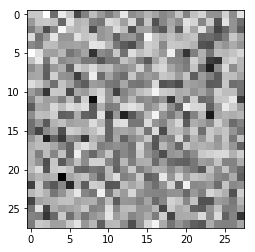

In [8]:
generate(5)

Sweet! We managed to create a picture that is utterly meaningless, but the neural network thinks is a '5' with very high certainty. We can actually take this a bit further. Let's generate an image that looks like one number, but the neural network is certain is another. To do this we will change our cost function a bit. Instead of just optimizing the input image to get a desired output label, we'll also optimize the input to look like a certain image at the same time. Our new cost function will be

$$ C = \|y - y_{hat}(x)\|^2_2 + \lambda \|x - x_{target}\|^2_2 $$

The added term tells us the distance from our $ x $ and some $ x_{target} $ (which should be the image we want our result to look like). Because we want to minimize $ C $, we also want to minimize the distance between our adversarial example and this image (which hopefully makes sense). The $ \lambda $ is hyperparameter that we can tune; it determines which is more important: optimizing for the desired output or optimizing for an image that looks like $ x_{target} $.

Here is a function that implements optimizing the modified cost function, called `sneaky_adversarial` because it is very sneaky. Note that the only difference between this function and `adversarial` is an additional term on the gradient descent update.

In [9]:
def sneaky_adversarial(net, n, m):
    x_target = test_data[m][0]
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(10000):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= .01 * (d + .05 * (x - x_target))

    return x

Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 don't work as well... no idea why...)

In [10]:
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find the first instance of m
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
    
    a = sneaky_adversarial(net, n, idx)
    x = np.round(net.feedforward(a), 2)
    
    print '\nWhat we want our adversarial example to look like: '
    plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print '\n'
    
    print 'Adversarial Example: '
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print 'Network Prediction: ' + str(np.argmax(x)) + '\n'
    
    print 'Network Output: \n' + str(x) + '\n'
    
    return a


What we want our adversarial example to look like: 


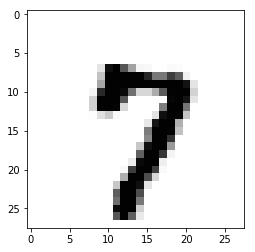



Adversarial Example: 


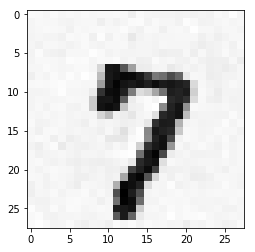

Network Prediction: 5

Network Output: 
[[ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.02]
 [ 0.  ]
 [ 0.97]
 [ 0.  ]
 [ 0.04]
 [ 0.  ]
 [ 0.  ]]



In [11]:
# sneaky_generate(target label, target digit)
x = sneaky_generate(5, 7)

In [12]:
def binary_thresholding(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    x = sneaky_generate(n, m)

    x = (x > .5).astype(float)
    
    print "With binary thresholding: "
    
    plt.imshow(x.reshape(28,28), cmap="Greys")
    plt.show()
    
    print "Prediction with binary thresholding: " + str(np.argmax(np.round(net.feedforward(x)))) + '\n'
    
    print "Network output: "
    print np.round(net.feedforward(x), 2)


What we want our adversarial example to look like: 


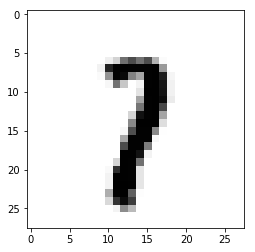



Adversarial Example: 


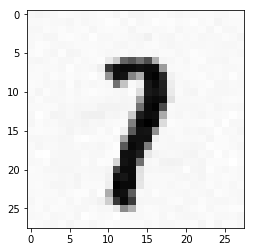

Network Prediction: 3

Network Output: 
[[ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.97]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.01]
 [ 0.  ]
 [ 0.  ]]

With binary thresholding: 


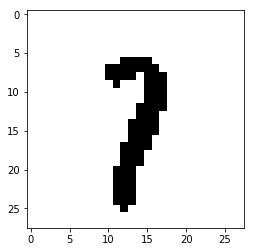

Prediction with binary thresholding: 0

Network output: 
[[ 0.  ]
 [ 0.15]
 [ 0.  ]
 [ 0.01]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.34]
 [ 0.  ]
 [ 0.  ]]


In [13]:
binary_thresholding(3, 7)